# **Model Training**

# **Classification of subtypes of ovarian cancer using RESNET50**

## **Importing the required libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset
import time
import os
import datetime
import copy
import shutil


In [59]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print('device =',device)

device = cuda:0


## **Dataset Organization**

In [3]:
train = pd.read_csv(r"/kaggle/input/UBC-OCEAN/train.csv")
test = pd.read_csv(r"/kaggle/input/UBC-OCEAN/test.csv")

In [4]:
train

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [ ]:
# Make it easier to access tma and non_tma images
tma = train[train["is_tma"] == True]
no_tma = train[train["is_tma"] == False]

no_tma['image_id_path'] = [f"{i}_thumbnail.png" for i in no_tma['image_id']]
tma['image_id_path'] = [f"{i}.png" for i in tma['image_id']]
test['image_id_path'] = [f"{i}_thumbnail.png" for i in test['image_id']]

In [ ]:
# Make it easier to access tma and non_tma images
tma = train[train["is_tma"] == True]
no_tma = train[train["is_tma"] == False]

# Define paths
tma_path = "/kaggle/input/UBC-OCEAN/train_images/"
no_tma_path = "/kaggle/input/UBC-OCEAN/train_thumbnails/"

# Add paths to image_id_path
tma['image_id_path'] = tma['image_id'].apply(lambda x: f"{tma_path}{x}.png")
no_tma['image_id_path'] = no_tma['image_id'].apply(lambda x: f"{no_tma_path}{x}_thumbnail.png")
test['image_id_path'] = test['image_id'].apply(lambda x: f"{no_tma_path}{x}_thumbnail.png")


In [63]:
# Save the selected random rows as a DataFrame
random_rows = train.sample(n=10)
test_df = pd.DataFrame(random_rows)

# Define paths
tma_path = "/kaggle/input/UBC-OCEAN/train_images/"
no_tma_path = "/kaggle/input/UBC-OCEAN/train_thumbnails/"

# Add paths to test_df
test_df['image_id_path'] = test_df.apply(lambda row: f"{tma_path}{row['image_id']}.png" if row['image_id'] in tma['image_id'].values else f"{no_tma_path}{row['image_id']}_thumbnail.png", axis=1)

# Print the DataFrame
print(test_df)

     image_id label  image_width  image_height  is_tma  \
479     57100  HGSC        51000         18220   False   
207     25923    CC        27128         27946   False   
351     40888    CC        76355         49135   False   
483     57598    CC        40495         29775   False   
266     32035  HGSC        16861         44075   False   
353     41361  HGSC        78149         21344   False   
284     34822    EC        43631         29642   False   
508     61493  HGSC        33746         33340   False   
405     47984  HGSC        47165         17046   False   
241     29615    CC        36742         27683   False   

                                         image_id_path  
479  /kaggle/input/UBC-OCEAN/train_thumbnails/57100...  
207  /kaggle/input/UBC-OCEAN/train_thumbnails/25923...  
351  /kaggle/input/UBC-OCEAN/train_thumbnails/40888...  
483  /kaggle/input/UBC-OCEAN/train_thumbnails/57598...  
266  /kaggle/input/UBC-OCEAN/train_thumbnails/32035...  
353  /kaggle/input/

In [64]:
# Creating a csv file for data downloaded from 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com'
data_path='/kaggle/input/ovarian-cancer-subtypes/OVC' 
subtypes=['Clear_Cell', 'Endometri', 'HGSC', 'LGSC', 'Mucinous', 'Non-Cancerous']
image_list=[] # to store images
for subtype in subtypes:
    subtype_path=os.path.join(data_path,subtype)
    for filename in os.listdir(subtype_path):
        image_path=os.path.join(subtype_path,filename) # getting the path for each image
        with Image.open(image_path) as img:
            width,height=img.size
        # Adding information to the image_list
        image_list.append(
        {
            'image_id':filename,
            'label':subtype,
            'image_width': width,
            'image_height': height,
            'is_tma': False,  
            'image_id_path': image_path 
            
        })
train_2=pd.DataFrame(image_list)
# Displaying the dataframe
train_2.head()
# Replace labels according to the specified mappings
train_2['label'] = train_2['label'].replace({
    'Clear_Cell': 'CC',
    'Endometri': 'EC',
    'Mucinous': 'MC',
    'Non-Cancerous': 'Non cancer'
})

train_2=train_2[train_2['label']!='Non cancer']
train_2

,image_id,label,image_width,image_height,is_tma,image_id_path
0,c24.JPG,CC,616,438,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Clea...
1,c27.JPG,CC,617,436,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Clea...
2,image_cc_0_3624.jpg,CC,621,439,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Clea...
3,image_cc_0_5090.jpg,CC,621,439,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Clea...
4,C54.JPG,CC,616,437,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Clea...
...,...,...,...,...,...,...
329,mucinus3.JPG,MC,611,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
330,mucinus43.JPG,MC,620,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
331,image_Mucinous_0_2479.jpg,MC,616,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
332,Cmucinus43.JPG,MC,620,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...


In [65]:
# Merge the two DataFrames
merged = pd.concat([no_tma, train_2], ignore_index=True)

# Print the merged DataFrame
merged


,image_id,label,image_width,image_height,is_tma,image_id_path
0,4,HGSC,23785,20008,False,/kaggle/input/UBC-OCEAN/train_thumbnails/4_thu...
1,66,LGSC,48871,48195,False,/kaggle/input/UBC-OCEAN/train_thumbnails/66_th...
2,281,LGSC,42309,15545,False,/kaggle/input/UBC-OCEAN/train_thumbnails/281_t...
3,286,EC,37204,30020,False,/kaggle/input/UBC-OCEAN/train_thumbnails/286_t...
4,431,HGSC,39991,40943,False,/kaggle/input/UBC-OCEAN/train_thumbnails/431_t...
...,...,...,...,...,...,...
842,mucinus3.JPG,MC,611,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
843,mucinus43.JPG,MC,620,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
844,image_Mucinous_0_2479.jpg,MC,616,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
845,Cmucinus43.JPG,MC,620,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...


In [66]:
train = pd.concat([tma,merged],ignore_index=True)

In [67]:
# Encode the labels
laben = LabelEncoder()

labels = train['label']
laben.fit(labels)
train['label'] = laben.transform(labels)

In [13]:
train

,image_id,label,image_width,image_height,is_tma,image_id_path
0,91,2,3388,3388,True,/kaggle/input/UBC-OCEAN/train_images/91.png
1,4134,4,2964,2964,True,/kaggle/input/UBC-OCEAN/train_images/4134.png
2,8280,2,2964,2964,True,/kaggle/input/UBC-OCEAN/train_images/8280.png
3,9200,4,3388,3388,True,/kaggle/input/UBC-OCEAN/train_images/9200.png
4,13568,3,2964,2964,True,/kaggle/input/UBC-OCEAN/train_images/13568.png
...,...,...,...,...,...,...
867,mucinus3.JPG,4,611,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
868,mucinus43.JPG,4,620,442,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
869,image_Mucinous_0_2479.jpg,4,616,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...
870,Cmucinus43.JPG,4,620,440,False,/kaggle/input/ovarian-cancer-subtypes/OVC/Muci...


In [68]:
class ImageLoader(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_id_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.data.iloc[idx, 1])
        
        return image, label


In [73]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


dataset = ImageLoader(train,train_transform)

train_ratio = 0.8
valid_ratio = 0.2

train_size = int(train_ratio * len(train))
valid_size = len(train) - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_data_loader = DataLoader(train_data, batch_size = 16, shuffle = False, num_workers = 4)
valid_data_loader = DataLoader(valid_data, batch_size = 16, shuffle = False, num_workers = 4)
classes = laben.classes_

In [16]:
classes

array(['CC', 'EC', 'HGSC', 'LGSC', 'MC'], dtype=object)

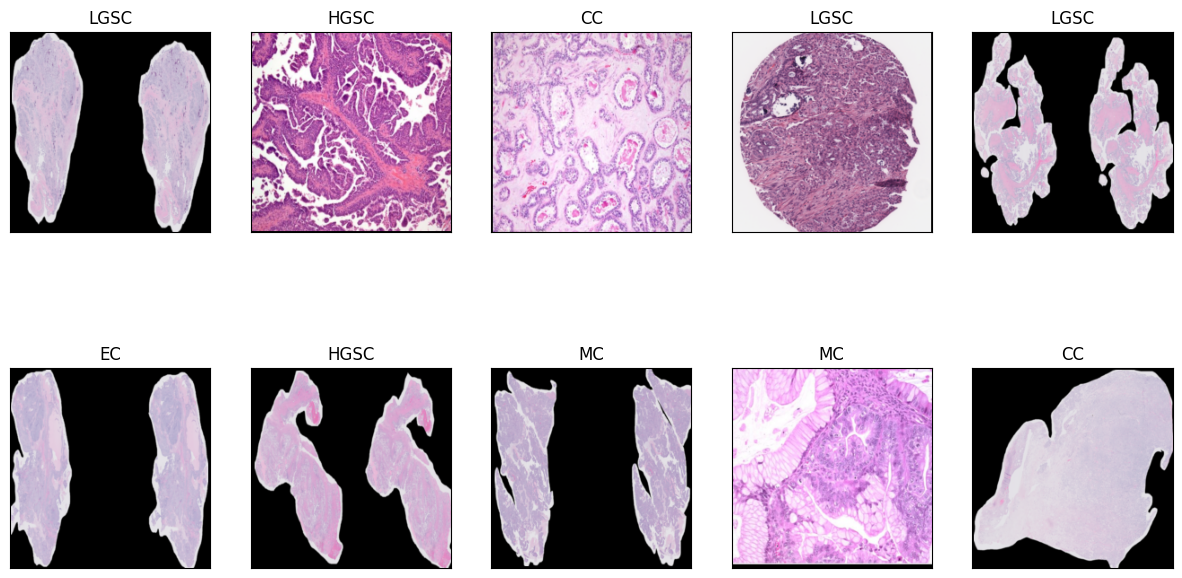

In [17]:
# Display random images
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    
for i, (images, lbls) in enumerate(train_data_loader, 0):
    images = invTrans(images)
    images, labels = images.numpy(), laben.inverse_transform(lbls)
    
    fig = plt.figure(figsize=(15,8))
    
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        label = lbls[idx]
        ax.set_title(labels[idx])
    break

In [74]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = 5

# Load ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for the new classification task
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Add a fully connected layer
    nn.ReLU(),  # Add ReLU activation
    nn.Dropout(0.5),  # Add dropout for regularization
    nn.Linear(512, num_classes)  # Add another fully connected layer for the final classification
)

model = model.to(device)

# Define optimizer and loss criteria with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.03)  # Adding weight decay for L2 regularization

# Name of the weights file
weights_filename = 'baseline_resnet50.pt'

train_acc = []  # Initialize train_acc list
train_loss = []  # Initialize train_loss list
val_acc = []  # Initialize val_acc list
val_loss = []  # Initialize val_loss list

# Training loop
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # Validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    
    # Save the model weights
    torch.save(model.state_dict(), weights_filename)

    # Set the model back to training mode
    model.train()

# Display final accuracy and loss
print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')


Epoch 1:
Epoch [1/30], Step [0/39], Loss: 1.6229
Epoch [1/30], Step [8/39], Loss: 1.4214
Epoch [1/30], Step [16/39], Loss: 1.5238
Epoch [1/30], Step [24/39], Loss: 1.4031
Epoch [1/30], Step [32/39], Loss: 1.4323
Train Loss: 1.494, Train Acc: 32.8%
Validation Loss: 1.440, Validation Acc: 35.1%

Epoch 2:
Epoch [2/30], Step [0/39], Loss: 1.3928
Epoch [2/30], Step [8/39], Loss: 1.2746
Epoch [2/30], Step [16/39], Loss: 1.3490
Epoch [2/30], Step [24/39], Loss: 1.3456
Epoch [2/30], Step [32/39], Loss: 1.3534
Train Loss: 1.452, Train Acc: 43.3%
Validation Loss: 1.407, Validation Acc: 42.4%

Epoch 3:
Epoch [3/30], Step [0/39], Loss: 1.3095
Epoch [3/30], Step [8/39], Loss: 1.2120
Epoch [3/30], Step [16/39], Loss: 1.2294
Epoch [3/30], Step [24/39], Loss: 1.3189
Epoch [3/30], Step [32/39], Loss: 1.3367
Train Loss: 1.420, Train Acc: 45.9%
Validation Loss: 1.383, Validation Acc: 45.8%

Epoch 4:
Epoch [4/30], Step [0/39], Loss: 1.2020
Epoch [4/30], Step [8/39], Loss: 1.1890
Epoch [4/30], Step [16/39

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 30
total_step = len(train_data_loader)

# Load ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for the new classification task
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model = model.to(device)

# Define optimizer and loss criteria with weight decay for regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.03)  # Adding weight decay for L2 regularization

# Name of the weights file
weights_filename = 'baseline_resnet50.pt'

train_acc = []  # Initialize train_acc list
train_loss = []  # Initialize train_loss list
val_acc = []  # Initialize val_acc list
val_loss = []  # Initialize val_loss list

# Training loop
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f'\nEpoch {epoch+1}:')
    
    for batch_idx, (data_, target_) in enumerate(train_data_loader):        
        data_, target_ = data_.to(device), target_.to(device)
        
        optimizer.zero_grad()
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 8 == 0:  
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, n_epochs, batch_idx, total_step, loss.item()))
    
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(f'Train Loss: {np.mean(train_loss):.3f}, Train Acc: {(100 * correct / total):.1f}%')
    
    # Validation
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        model.eval()
        for data_t, target_t in valid_data_loader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            
            val_running_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            val_correct += torch.sum(pred_t == target_t).item()
            val_total += target_t.size(0)
            
        val_acc.append(100 * val_correct / val_total)
        val_loss.append(val_running_loss / len(valid_data_loader))

    print(f'Validation Loss: {np.mean(val_loss):.3f}, Validation Acc: {(100 * val_correct / val_total):.1f}%')
    
    # Save the model weights
    torch.save(model.state_dict(), weights_filename)

    # Set the model back to training mode
    model.train()

# Display final accuracy and loss
print(f'\nFinal Training Loss: {np.mean(train_loss):.3f}, Final Training Acc: {(100 * correct / total):.1f}%')
print(f'Final Validation Loss: {np.mean(val_loss):.3f}, Final Validation Acc: {(100 * val_correct / val_total):.1f}%')


# **Model Evaluation**

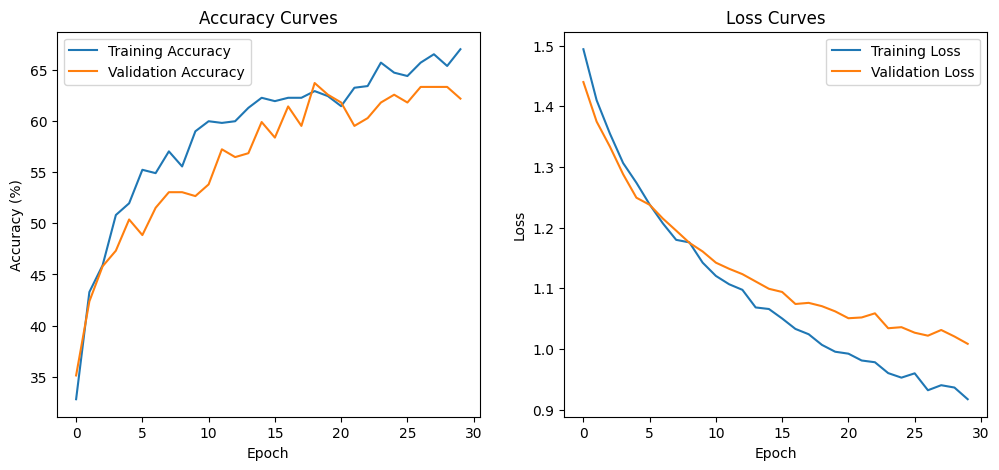

Classification Report:
              precision    recall  f1-score   support

          CC       0.66      0.65      0.66        66
          EC       0.64      0.57      0.60        61
        HGSC       0.54      0.76      0.63        74
        LGSC       0.00      0.00      0.00        14
          MC       0.77      0.64      0.70        47

    accuracy                           0.63       262
   macro avg       0.52      0.52      0.52       262
weighted avg       0.61      0.63      0.61       262



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


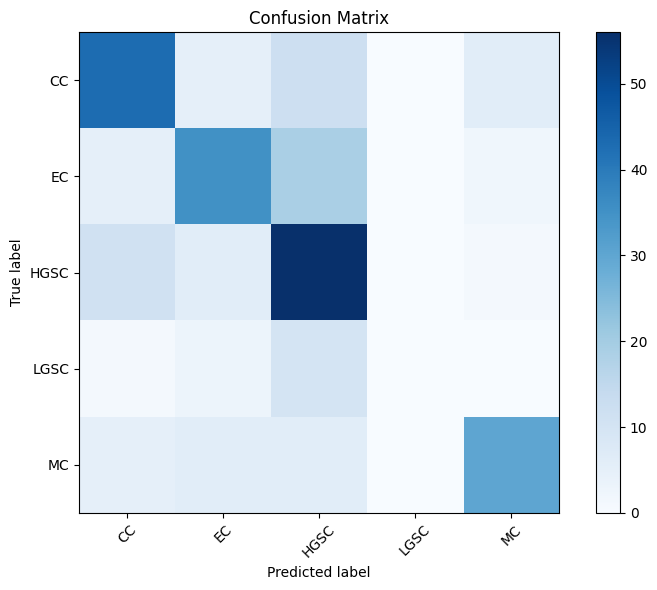

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training and validation curves
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert class indices to class labels
class_labels = [classes[i] for i in range(len(classes))]

print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


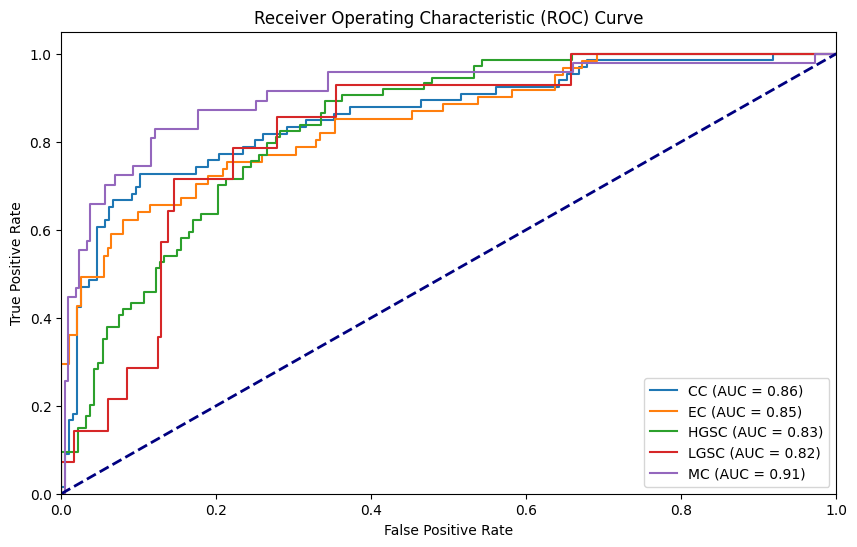

In [76]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted probabilities
true_labels = []
pred_probs = []

# Switch model to evaluation mode
model.eval()

# Iterate through the validation data loader to get predictions and true labels
with torch.no_grad():
    for data, target in valid_data_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        
        # Convert tensor to numpy array and append to lists
        true_labels.extend(target.cpu().numpy())
        pred_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Initialize dictionary to store ROC AUC scores for each class
roc_auc_scores = {}

# Calculate ROC AUC scores for each class
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **Making Predictions**

In [83]:
# Define the TestImageLoader class
class TestImageLoader(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_id_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of TestImageLoader
test_dataset = TestImageLoader(test_df, transform=valid_transform)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Iterate over the test data, make predictions, and store the results
y_pred = []

for images in test_loader:
    # Move images to the device
    images = images.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(images)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    y_pred.append(predicted.item())

# Map numerical labels to actual labels
label_map = {2: 'HGSC', 1: 'EC', 4: 'MC', 0: 'CC', 3: 'LGSC'}
test_df['predicted_label'] = [label_map[p] for p in y_pred]

# Display actual and predicted labels
print(test_df[['image_id', 'label', 'predicted_label']])


     image_id label predicted_label
479     57100  HGSC            HGSC
207     25923    CC              CC
351     40888    CC            HGSC
483     57598    CC            HGSC
266     32035  HGSC              EC
353     41361  HGSC            HGSC
284     34822    EC            HGSC
508     61493  HGSC            HGSC
405     47984  HGSC              CC
241     29615    CC              CC


In [84]:
from sklearn.metrics import classification_report

# Extract actual and predicted labels
actual_labels = test_df['label'].tolist()
predicted_labels = test_df['predicted_label'].tolist()

# Generate classification report
report = classification_report(actual_labels, predicted_labels)

# Display the classification report
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

          CC       0.67      0.50      0.57         4
          EC       0.00      0.00      0.00         1
        HGSC       0.50      0.60      0.55         5

    accuracy                           0.50        10
   macro avg       0.39      0.37      0.37        10
weighted avg       0.52      0.50      0.50        10



Predicted Class: HGSC, Confidence: 60.37%


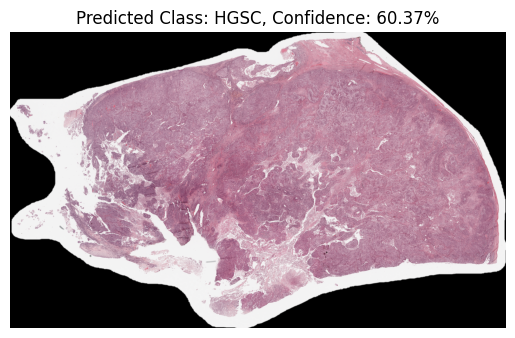

In [96]:
# Load the saved model
model = models.resnet50(pretrained=False)  # Define the model architecture
model.fc = nn.Linear(model.fc.in_features, len(classes))  # Modify the final layer for classification
model.load_state_dict(torch.load('baseline_resnet50.pt', map_location=torch.device('cpu')))
model.eval()  # Set model to evaluation mode

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess the image
def preprocess_image(image):
    img = Image.open(image).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img

# Function to make predictions
def predict(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Perform inference
    with torch.no_grad():
        output = model(img)
    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1)[0]
    # Get predicted class index
    predicted_idx = torch.argmax(output, dim=1).item()
    # Get predicted class label
    predicted_label = classes[predicted_idx]
    # Get the percentage of confidence for the predicted class
    confidence_percentage = probabilities[predicted_idx] * 100
    return predicted_label, confidence_percentage.item()

# Example usage
image_path = '/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png'  # Replace with the path to your image
predicted_class, confidence = predict(image_path)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')

# Display the image with the predicted class label and confidence
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%', fontsize=12)
plt.show()


In [88]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the TestImageLoader class
class TestImageLoader(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_id_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define transformations
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of TestImageLoader
test_dataset = TestImageLoader(test_df, transform=valid_transform)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Iterate over the test data, make predictions, and store the results
y_pred = []

for images in test_loader:
    # Move images to the device
    images = images.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = k(images)

    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    y_pred.append(predicted.item())

# Map numerical labels to actual labels
label_map = {2: 'HGSC', 1: 'EC', 4: 'MC', 0: 'CC', 3: 'LGSC'}
test_df['predicted_label'] = [label_map[p] for p in y_pred]

# Display actual and predicted labels
print(test_df[['image_id', 'label', 'predicted_label']])


     image_id label predicted_label
479     57100  HGSC            HGSC
207     25923    CC              CC
351     40888    CC              CC
483     57598    CC            HGSC
266     32035  HGSC            HGSC
353     41361  HGSC            HGSC
284     34822    EC            HGSC
508     61493  HGSC            HGSC
405     47984  HGSC              EC
241     29615    CC              CC
